In [ ]:
!pip install bs4==0.0.1

     |████████████████████████████████| 115 kB 7.3 MB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1271 sha256=18b06c485ca9288a362ecb756fe083d7ae8655d2441514ac5a14fd7fc0a36516
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
from sklearn import preprocessing
def retrieve_iMDB_links(pages, start=1):
    
    links = []
    for i in range(pages):
        url = f"https://www.imdb.com/search/title/?release_date=2018-01-01,2020-12-31&view=simple&count=100"
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page)
        find_urls = soup.find_all(class_="lister-item-index unbold text-primary")
        link_list = [i.findNext().findChildren()[0]["href"] for i in find_urls]
        links.extend(link_list)
        start += 10
    return links


In [ ]:
iMDB_links = retrieve_iMDB_links(1)

In [ ]:
def parse_iMDB_features(link):
    
    base_url = "https://www.imdb.com"

    url = base_url + link

    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page)

    headers = [
        "movie title",
        "imdb rating",
        "imdb raters",
        "BBFC",
        "genres",
        "director",
        "writer",
        "stars",
        "country",
        "language",
        "release date",
        "budget",
        "opening weekend",
        "cumulative worldwide",
        "production companies",
        "runtime (min)",
    ]

    
    try:
        title = (
            soup.find(class_="title_wrapper").find("h1").text.split("\xa0")[0]
        )
    except:
        title = None

    
    try:
        rating_10 = float(soup.find(class_="ratingValue").span.text)
    except:
        rating_10 = None

    
    try:
        raters = int(
            soup.find(class_="ratingValue")
            .strong["title"]
            .split()[3]
            .replace(",", "")
        )
    except:
        raters = None

    
    BBFC_options = [
        "U",
        "PG",
        "12A",
        "12",
        "15",
        "18",
        "R18"
    ]
    try:
        BBFC = soup.find(class_="subtext").text
        BBFC = BBFC.split("\n")[1].strip()
        if BBFC not in BBFC_options:
            BBFC = None
    except:
        BBFC = None

    
    try:
        genre = soup.find("h4", text=re.compile("Genre")).findParent().text
        genre = [
            ele.strip().replace("\xa0|", "") for ele in genre.split("\n")[2:-1]
        ]
    except:
        genre = None

    
    try:
        director = (
            soup.find_all(class_="credit_summary_item")[0]
            .text.split("\n")[-1]
            .strip()
        )
    except:
        director = None

    
    try:
        writer = (
            soup.find_all(class_="credit_summary_item")[1]
            .text.split("\n")[2]
            .split(",")[0]
        )
        writer = writer.split("(")[0].strip()
    except:
        writer = None

    
    try:
        stars_unclean = (
            soup.find_all(class_="credit_summary_item")[2]
            .text.split("\n")[2]
            .split(",")
        )
        stars = [i.replace("|", "").strip() for i in stars_unclean]
    except:
        stars = None

    
    try:
        country = soup.find("h4", text=re.compile("Country")).findNext().text
    except:
        country = None

    
    try:
        language = soup.find("h4", text=re.compile("Language")).findNext().text
    except:
        language = None

    
    try:
        release_date = (
            soup.find("h4", text=re.compile("Release Date")).findParent().text
        )
        release_date = (
            release_date.split("\n")[1].split(":")[1].split("(")[0].strip()
        )
        release_date = datetime.strptime(release_date, "%d %B %Y").date()
    except:
        release_date = None

    
    try:
        budget = soup.find("h4", text=re.compile("Budget")).findParent().text
        budget = budget.split("\n")[1].split(":")[1]
        budget = money_to_int(budget)
    except:
        budget = None

    
    try:
        opening_weekend = (
            soup.find("h4", text=re.compile("Opening Weekend"))
            .findParent()
            .text
        )
        opening_weekend = (
            opening_weekend.split("\n")[1].split(":")[1].strip(" ,")
        )
        opening_weekend = money_to_int(opening_weekend)
    except:
        opening_weekend = None

   

   
    try:
        worldwide = (
            soup.find("h4", text=re.compile("Cumulative Worldwide"))
            .findParent()
            .text
        )
        worldwide = worldwide.split(":")[1].strip()
        worldwide = money_to_int(worldwide)
    except:
        worldwide = None

    
    try:
        production_co = (
            soup.find("h4", text=re.compile("Production Co")).findParent().text
        )
        production_co = production_co.split("\n")[2].strip()
        production_co = [co.strip() for co in production_co.split(",")]
    except:
        production_co = None

    
    try:
        runtime = soup.find("h4", text=re.compile("Runtime")).findParent().text
        runtime = int(runtime.split("\n")[2].split(" ")[0])
    except:
        runtime = None

    data_list = [
        title,
        rating_10,
        raters,
        BBFC,
        genre,
        director,
        writer,
        stars,
        country,
        language,
        release_date,
        budget,
        opening_weekend,
        worldwide,
        production_co,
        runtime,
    ]

    movie_dict = dict(zip(headers, data_list))

    return movie_dict




In [ ]:
print(iMDB_links)

['/title/tt8332922/', '/title/tt7255502/', '/title/tt9251798/', '/title/tt6644200/', '/title/tt4236770/', '/title/tt7945720/', '/title/tt9054904/', '/title/tt9544034/', '/title/tt9561862/', '/title/tt1190634/', '/title/tt6772524/', '/title/tt6723592/', '/title/tt8317568/', '/title/tt9620292/', '/title/tt8111088/', '/title/tt9686194/', '/title/tt10886166/', '/title/tt9770150/', '/title/tt7817340/', '/title/tt9072202/', '/title/tt8879940/', '/title/tt7131622/', '/title/tt10272386/', '/title/tt7235466/', '/title/tt8372094/', '/title/tt10986410/', '/title/tt7587890/', '/title/tt7126948/', '/title/tt7221388/', '/title/tt10048342/', '/title/tt7562112/', '/title/tt4154796/', '/title/tt5180504/', '/title/tt7737786/', '/title/tt11794642/', '/title/tt7472896/', '/title/tt8740790/', '/title/tt11032374/', '/title/tt8368512/', '/title/tt2222042/', '/title/tt7366338/', '/title/tt8421350/', '/title/tt7608248/', '/title/tt6474378/', '/title/tt8367814/', '/title/tt7053188/', '/title/tt8772262/', '/titl

In [ ]:
count = 0
iMDB_converted_data = []
for link in movie_links:
    iMDB_converted_data.append(parse_iMDB_features(link))
    count += 1
    if count % 50 == 0:
        with open('IMDb_data_t.pickle', 'wb') as to_write:
            pickle.dump(iMDB_converted_data, to_write)

NameError: name 'movie_links' is not defined

In [ ]:
iMDB_data = pd.DataFrame(iMDB_converted_data)

In [ ]:
dataframe = pd.DataFrame(pd.read_pickle('IMDb_data_test.pickle'))

In [ ]:
print(dataframe)

                         movie title  imdb rating  BBFC  \
0                         The Father          8.3   12A   
1                        Snowpiercer          6.9    15   
2              Promising Young Woman          7.5    15   
3                     Justice League          6.2   12A   
4     Godzilla: King of the Monsters          6.0   12A   
...                              ...          ...   ...   
1995                       Chernobyl          9.4    15   
1996           Yakusoku no Neverland          8.6    15   
1997                   Young Sheldon          7.5    PG   
1998                        The Frog          8.2  None   
1999                   Black Panther          7.3   12A   

                                                 genres  \
0                                               [Drama]   
1                     [Action, Drama, Sci-Fi, Thriller]   
2                              [Crime, Drama, Thriller]   
3                  [Action, Adventure, Fantasy, Sci-Fi]

In [ ]:

iMDB_dataframe = dataframe.copy()


In [ ]:
iMDB_dataframe.drop_duplicates(subset=['movie title'],inplace=True)

In [ ]:
iMDB_dataframe.set_index('movie title',inplace=True)

In [ ]:
iMDB_dataframe_drop = iMDB_dataframe

In [ ]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie title           2000 non-null   object 
 1   imdb rating           2000 non-null   float64
 2   BBFC                  1740 non-null   object 
 3   genres                2000 non-null   object 
 4   director              2000 non-null   object 
 5   writer                1860 non-null   object 
 6   stars                 800 non-null    object 
 7   country               2000 non-null   object 
 8   language              2000 non-null   object 
 9   release date          0 non-null      object 
 10  budget                0 non-null      object 
 11  production companies  1980 non-null   object 
 12  runtime (min)         1960 non-null   float64
dtypes: float64(2), object(11)
memory usage: 203.2+ KB


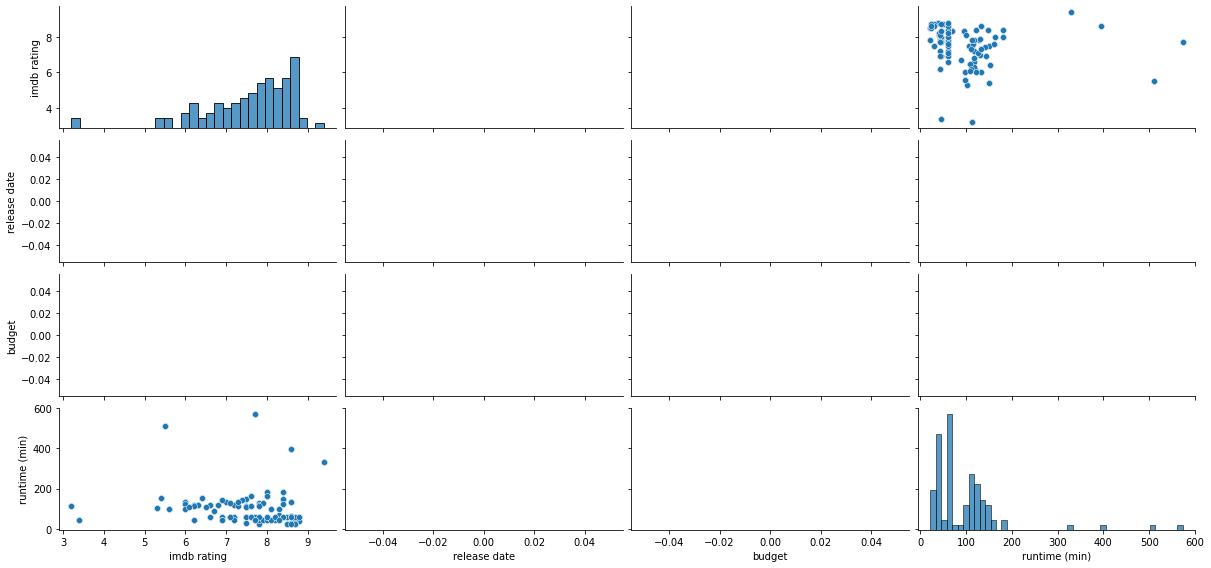

In [ ]:
sns.pairplot(dataframe, height=2, aspect=2.15)
plt.savefig('pairplot.png');

In [ ]:
iMDB_drop = iMDB_dataframe_drop[iMDB_dataframe_drop['imdb rating'].notna()]

In [ ]:
iMDB_drop = iMDB_drop[iMDB_drop['runtime (min)'].notna()]

In [ ]:
X, y = iMDB_drop[['runtime (min)']], iMDB_drop['imdb rating']

In [ ]:
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.0236


In [ ]:
BBFC_dataframe = pd.get_dummies(iMDB_drop['BBFC'])



In [ ]:
BBFC_dummies = pd.concat([iMDB_drop, BBFC_dataframe], axis=1)

In [ ]:
X, y = BBFC_dummies[['runtime (min)',
        "PG",
        "12",
        "15",
        "18"]], BBFC_dummies['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.0927


In [ ]:
Genre_dataframe = pd.Series(BBFC_dummies['genres'])

In [ ]:
Genre_dataframe = pd.get_dummies(Genre_dataframe.apply(pd.Series).stack()).sum(level=0)

In [ ]:
dataframe_genresandBBFC = pd.concat([BBFC_dummies, Genre_dataframe], axis=1)


In [ ]:
dataframe_genresandBBFC.drop(labels=['budget', 'release date'],axis=1,inplace=True)

In [ ]:
X, y = dataframe_genresandBBFC[['runtime (min)',
        "PG",
        "12A",
        "12",
        "15",
        "18",'Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']], dataframe_genresandBBFC['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.4131


In [ ]:
iMDB_drop[iMDB_drop['director']==''].index.tolist()

['New Amsterdam',
 'Ted Lasso',
 'Cobra Kai',
 'The Expanse',
 'The Last Kingdom',
 'My Hero Academia',
 'Jujutsu Kaisen',
 'A Discovery of Witches',
 'Yakusoku no Neverland']

In [ ]:
empty_dir = iMDB_drop[iMDB_drop['director']==''].index.values.tolist()

In [ ]:
def directors_list(directors):
   
    if "," in directors:
        return [name.strip() for name in directors.split(",")]
    else:
        return [directors]


def remove_paren(directors):
   
    director_list = []
    for director in directors:
        if "(" in director:
            director_clean = director.split("(")[0].strip()
            director_list.append(director_clean)
        else:
            director_list.append(director)
    return director_list

In [ ]:
iMDB_drop['director'] = iMDB_drop['director'].apply(lambda x: directors_list(x))


In [ ]:
iMDB_drop['director'] = iMDB_drop['director'].apply(lambda x: remove_paren(x))

In [ ]:
dataframe_director_exploded = iMDB_drop.explode('director')

In [ ]:
director_10 = dataframe_director_exploded['director'].value_counts()[:10].index.tolist()

In [ ]:
def top_directors(directors):
    director_list = []
    for director in directors:
        if director in director_10:
            director_list.append(director)
    return director_list

In [ ]:
iMDB_drop['top directors'] = iMDB_drop['director'].apply(lambda x: top_directors(x))

In [ ]:
director_dataframe = pd.get_dummies(iMDB_drop['top directors'].apply(pd.Series).stack()).sum(level=0)

In [ ]:
dataframe_director_model = pd.concat([dataframe_genresandBBFC, director_dataframe], axis=1)

In [ ]:
dataframe_director_model.drop(labels=['genres','director','writer','stars','country','language','production companies'],axis=1,inplace=True)
# Let's take out the columns we're not using

In [ ]:
dataframe_director_model.replace(np.nan,0,inplace=True)

In [ ]:
X, y = dataframe_director_model.iloc[:,2:], dataframe_director_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5268


In [ ]:
writer_dataframe = pd.get_dummies(iMDB_drop['writer'])

In [ ]:

writer_10 = iMDB_drop.writer.value_counts()[:10].index.tolist()


In [ ]:
dataframe_writer_model = pd.concat([dataframe_director_model, writer_dataframe[writer_10]],axis=1)

In [ ]:
X, y = dataframe_writer_model.iloc[:,2:], dataframe_writer_model['imdb rating']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

R-squared: 0.5959


In [ ]:
from sklearn.model_selection import train_test_split
X, y = dataframe_writer_model.iloc[:,2:,], dataframe_writer_model['imdb rating']
X, X_test, y, y_test = train_test_split(X, y, test_size=.1, random_state=10)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=10)

In [ ]:
X, y = dataframe_writer_model.iloc[:,2:,], dataframe_writer_model['imdb rating']


In [ ]:
print(dataframe_writer_model)

                                imdb rating BBFC  runtime (min)  12  12A  15  \
movie title                                                                    
The Father                              8.3  12A           97.0   0    1   0   
Snowpiercer                             6.9   15           60.0   0    0   1   
Promising Young Woman                   7.5   15          113.0   0    0   1   
Justice League                          6.2  12A          120.0   0    1   0   
Godzilla: King of the Monsters          6.0  12A          132.0   0    1   0   
...                                     ...  ...            ...  ..  ...  ..   
Sex Education                           8.3   18           45.0   0    0   0   
Chernobyl                               9.4   15          330.0   0    0   1   
Yakusoku no Neverland                   8.6   15           23.0   0    0   1   
Young Sheldon                           7.5   PG           30.0   0    0   0   
Black Panther                           

In [ ]:
dataframe_writer_model.info

<bound method DataFrame.info of                                 imdb rating BBFC  runtime (min)  12  12A  15  \
movie title                                                                    
The Father                              8.3  12A           97.0   0    1   0   
Snowpiercer                             6.9   15           60.0   0    0   1   
Promising Young Woman                   7.5   15          113.0   0    0   1   
Justice League                          6.2  12A          120.0   0    1   0   
Godzilla: King of the Monsters          6.0  12A          132.0   0    1   0   
...                                     ...  ...            ...  ..  ...  ..   
Sex Education                           8.3   18           45.0   0    0   0   
Chernobyl                               9.4   15          330.0   0    0   1   
Yakusoku no Neverland                   8.6   15           23.0   0    0   1   
Young Sheldon                           7.5   PG           30.0   0    0   0   
Black Pa

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X, y = np.array(X), np.array(y) 
lr = LinearRegression()


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state = 1)
cv_lr_r2s, cv_lr_reg_r2s = [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    lr = LinearRegression()
    lr_reg = Ridge(alpha=1)

    lr.fit(X_train, y_train)
    cv_lr_r2s.append(lr.score(X_val, y_val))
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lr_reg.fit(X_train_scaled, y_train)
    cv_lr_reg_r2s.append(lr_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lr_r2s)
print('Ridge scores: ', cv_lr_reg_r2s, '\n')

print(f'Simple mean cv R-squared: {np.mean(cv_lr_r2s):.3f} +- {np.std(cv_lr_r2s):.3f}')
print(f'Ridge mean cv R-squared: {np.mean(cv_lr_reg_r2s):.3f} +- {np.std(cv_lr_reg_r2s):.3f}')

Simple regression scores:  [-1.2332608621062366, -0.40758916094145947, -2.026255760546843, -0.19525127250003083, -0.7555220325437733, 0.528688266859646, -5.218416701622146, -2.062777929512896, -0.6189455170404898, -0.17112597599325463]
Ridge scores:  [-1.0867296279487233, -0.3368217727833096, -1.8256920505636898, 0.16731941143171758, -0.6702256402365905, 0.6273517463152258, -3.808507085363738, -1.8313060257583946, -0.5444117424952117, -0.18373861441304928] 

Simple mean cv R-squared: -1.216 +- 1.542
Ridge mean cv R-squared: -0.949 +- 1.211


In [ ]:
alphas = np.logspace(-5, 5, 15)

ridge = RidgeCV(alphas=alphas, normalize = True)

ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05]),
        normalize=True)

In [ ]:
ridge.coef_

array([-5.37175911e-04,  4.20000368e-03, -2.51171866e-01,  1.13904046e-01,
        5.95108915e-02,  2.53758725e-01, -9.82215907e-02, -2.05603095e-01,
        3.45356246e-01,  1.46030161e-01,  1.53927071e-01,  1.44922575e-01,
        1.97960205e-01,  0.00000000e+00, -2.27754249e-01,  4.24542258e-01,
       -2.68167370e-01, -3.08125687e-03,  1.07714805e-01,  1.69024918e-01,
       -1.33533234e-01,  8.89346556e-02,  2.34080258e-01, -1.30442276e-01,
        4.52731817e-01, -1.70346055e-01,  2.86104093e-01,  0.00000000e+00,
       -1.50276695e-01,  1.11805858e-01, -2.97077488e-01, -8.71968895e-02,
        0.00000000e+00,  0.00000000e+00, -2.88245154e-01, -3.07668348e-01,
        0.00000000e+00, -3.20894568e-01,  0.00000000e+00,  1.40654270e-01,
       -8.11189451e-01,  1.46030161e-01,  1.07714805e-01,  0.00000000e+00,
       -8.67046775e-01,  1.78284914e-01])

In [ ]:
ridge.alpha_


1.0

In [ ]:
print(ridge.score(X_val, y_val))


-0.22614495662995204


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr_reg.fit(X_train_scaled, y_train);

In [ ]:
test_set_pred = lr_reg.predict(X_test_scaled)

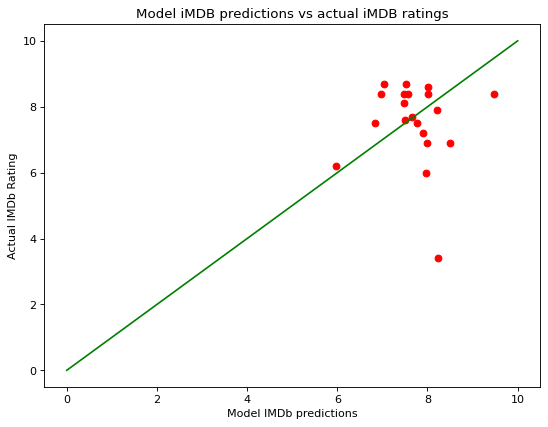

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(test_set_pred, y_test, alpha=1, color='Red' )
plt.plot(np.linspace(0,10), np.linspace(0,10), color='Green')

plt.title('Model iMDB predictions vs actual iMDB ratings')
plt.xlabel('Model IMDb predictions')
plt.ylabel('Actual IMDb Rating');

In [ ]:
print('Ridge R-squared: {:.4f}'.format(r2_score(y_test, test_set_pred))) 

Ridge R-squared: -0.3909


In [ ]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

print('MAE: {:.4f}'.format(mae(y_test, test_set_pred)))

MAE: 1.0257


In [ ]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='red',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

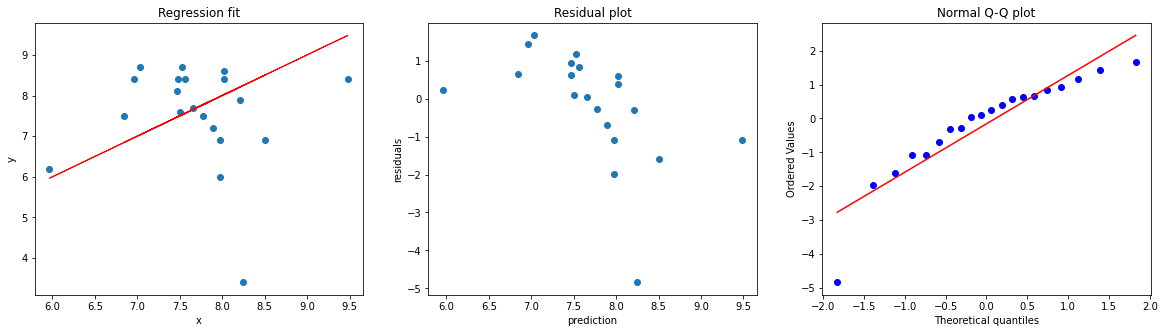

In [ ]:
diagnostic_plot(test_set_pred, y_test)

In [ ]:
!pip install xgboost
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [ ]:
# XGboost
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X,
         y)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(256, activation='relu',input_shape=(46,)),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

2.4.1


In [ ]:
# normalise here


NN = build_and_compile_model()
NN.fit(X, y, validation_data=(X_val, y_val), epochs=50, batch_size=1)

Epoch 1/50
78/78 [==============================] - 3s 29ms/step - loss: 5.1346 - val_loss: 5.4461
Epoch 2/50
78/78 [==============================] - 0s 4ms/step - loss: 4.6088 - val_loss: 5.8445
Epoch 3/50
78/78 [==============================] - 0s 4ms/step - loss: 4.8975 - val_loss: 5.8025
Epoch 4/50
78/78 [==============================] - 0s 4ms/step - loss: 5.5523 - val_loss: 5.0620
Epoch 5/50
78/78 [==============================] - 0s 3ms/step - loss: 3.3419 - val_loss: 4.7894
Epoch 6/50
78/78 [==============================] - 0s 4ms/step - loss: 3.2905 - val_loss: 4.6785
Epoch 7/50
78/78 [==============================] - 0s 3ms/step - loss: 4.2199 - val_loss: 4.2556
Epoch 8/50
78/78 [==============================] - 0s 3ms/step - loss: 3.6027 - val_loss: 3.9522
Epoch 9/50
78/78 [==============================] - 0s 3ms/step - loss: 2.0624 - val_loss: 3.0211
Epoch 10/50
78/78 [==============================] - 0s 3ms/step - loss: 1.6491 - val_loss: 1.4633
Epoch 11/50
78/78 

In [ ]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='red',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=807fde48-b748-4f76-9f2e-6abbdbc68210' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>